Epoch 0: EQM entrainement: [0.1825927] Taux correct: 0.89124
Epoch 0: EQM test: [0.17856127] Taux correct: 0.8935
Epoch 1: EQM entrainement: [0.14158795] Taux correct: 0.91704
Epoch 1: EQM test: [0.14434722] Taux correct: 0.9122
Epoch 2: EQM entrainement: [0.12534901] Taux correct: 0.92562
Epoch 2: EQM test: [0.13278509] Taux correct: 0.9181
Epoch 3: EQM entrainement: [0.1117503] Taux correct: 0.93282
Epoch 3: EQM test: [0.12136186] Taux correct: 0.924
Epoch 4: EQM entrainement: [0.1032602] Taux correct: 0.93762
Epoch 4: EQM test: [0.1142845] Taux correct: 0.9297
Epoch 5: EQM entrainement: [0.09858168] Taux correct: 0.94076
Epoch 5: EQM test: [0.11369991] Taux correct: 0.9304
Epoch 6: EQM entrainement: [0.0986575] Taux correct: 0.94124
Epoch 6: EQM test: [0.11318471] Taux correct: 0.9331
Epoch 7: EQM entrainement: [0.09013705] Taux correct: 0.94694
Epoch 7: EQM test: [0.10845767] Taux correct: 0.9345
Epoch 8: EQM entrainement: [0.08757351] Taux correct: 0.94906
Epoch 8: EQM test: [0.10

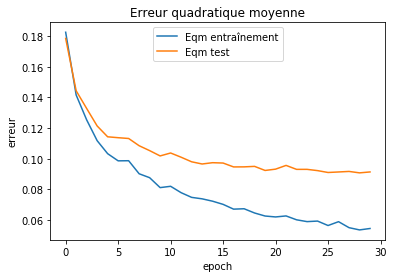

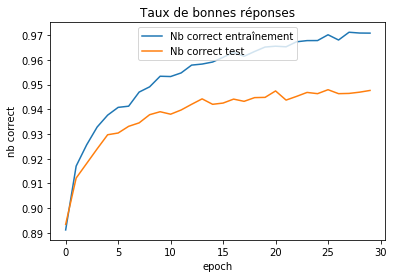

In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline
"""
Exemple de réseau de neuronne à propagation avant et rétropropagation de l'erreur pour l'apprentissage
Application aux données MNIST
"""
import random
import numpy as np
np.random.seed(42) # pour reproduire les mêmes résultats
random.seed(42)
import matplotlib.pyplot as plt

def sigmoide(z):
    """Fonction sigmoide"""
    return 1.0/(1.0+np.exp(-z))

def derivee_sigmoide(z):
    """Dérivée de la fonction sigmoide"""
    return sigmoide(z)*(1-sigmoide(z))

def dJ_dz_final(activation_finale, y):
    """Dérivée de J par rapport à z pour la couche finale"""
    return (activation_finale-y)

class RNA(object):
    """ Un RNA est un réseau de neuronnes artificiel multi-couche.
    """
        
    def __init__(self, liste_nc):
        """ liste_nc[c] contient le nombre de neurones de la couche c, c = 0 ...nombre_couches-1
        la couche d'indice 0 est la couche d'entrée
        liste_nc[nombre_couches-1] doit correspondre au nombre de catégories des y (sortie)
        
        w[c] est la matrice des poids entre la couche c et c+1 (NB différent du livre à cause de l'indice 0)
        w[c][i,j] est le poids entre le neuronne i de la couche c+1 et j de la couche c
        i = 0 correspond au biais par convention
        les poids sont initialisés avec un nombre aléatoire selon une distribution N(0,1)
        """
        self.liste_nc = liste_nc
        self.nombre_couches = len(liste_nc)
        # Initialiser les matrices des poids w avec des valeurs aleatoires N(0,1)
        # NB w[c] correspond a la couche c+1
        self.w = [np.random.randn(x+1,y) for x, y in zip(liste_nc[:-1], liste_nc[1:])]

    def propagation_avant_w(self, activation):
        """
        Traiter une entrée par propagation avant
        
        activation: activation initiale qui correspond aux entrées (taille self.liste_nc[0])
        retourne l'activation de sortie après propagation avant"""
        
        for un_w in self.w:
            activation = np.vstack((np.ones(1),sigmoide(np.dot(un_w.transpose(),activation))))
        return activation

    def entrainer_par_mini_lot(self,donnees_entrainement,donnees_test,nombre_epochs,taille_mini_lot,taux):
        """
        Entrainer le RNA par mini-lots
        Affiche le nombre de bons résultats des donnees_test pour chaque epoch
        
        donnees_entrainement : liste de tuples (x,y) pour l'entrainement où
            x est un tableau de taille (liste_nc[0],1) où n est la taille des entrées
            y est un encodage bitmap de la catégorie en tableau de taille liste_nc[nombre_couches-1]
        donnees_test : liste de tuples (x,y) pour les tests
            x est un tableau de taille (liste_nc[0],1) où n est la taille des entrées
            y un int où 0<=y< nombre de catégories
        nombre_epochs : nombre de passe d'entrainement
        taille_mini_lot : la taille de chacun des mini-lots
        taux : vitesse d'apprentissage
        """
        n_test = len(donnees_test)
        n_ent = len(donnees_entrainement)
        self.liste_eqm_ent = []
        self.liste_ok_ent = []
        self.liste_eqm_test = []
        self.liste_ok_test = []
        
        for j in range(nombre_epochs):
            random.shuffle(donnees_entrainement)
            mini_lots = [donnees_entrainement[k:k+taille_mini_lot] for k in range(0, n_ent, taille_mini_lot)]
            # Entrainer un mimi-lot à la fois
            for mini_lot in mini_lots:
                # Initialiser les gradiants totaux à 0
                liste_dJ_dw = [np.zeros(w.shape) for w in self.w]
                for x, y in mini_lot:
                    dJ_dw_une_ligne = self.retropropagation_w(x, y)
                    # ajouter les gradiants d'une observation aux totaux partiels du lot
                    liste_dJ_dw = [dJ_dw+dJ_dw_1 for (dJ_dw, dJ_dw_1) in zip(liste_dJ_dw, dJ_dw_une_ligne)]
                # mettre à jour les paramètres du RNA avec les gradiants du lot    
                self.w = [w-(taux/len(mini_lot))*dw  for (w, dw) in zip(self.w, liste_dJ_dw)]
            
             # Calcul des métriques de performance
            eqm_ent,ok_ent = self.metriques(donnees_entrainement)
            eqm_test,ok_test = self.metriques(donnees_test)
            self.liste_eqm_ent.append(eqm_ent/n_ent)
            self.liste_ok_ent.append(ok_ent/n_ent)
            self.liste_eqm_test.append(eqm_test/n_test)
            self.liste_ok_test.append(ok_test/n_test)
            print("Epoch {0}: EQM entrainement: {1} Taux correct: {2}".format(j, eqm_ent/n_ent,ok_ent/n_ent))
            print("Epoch {0}: EQM test: {1} Taux correct: {2}".format(j, eqm_test/n_test,ok_test/n_test))

        # Affichage des graphiques d'évolution des performances par epoch
        plt.plot(np.arange(0,nombre_epochs),self.liste_eqm_ent,label='Eqm entraînement')
        plt.plot(np.arange(0,nombre_epochs),self.liste_eqm_test,label='Eqm test')
        plt.title("Erreur quadratique moyenne")
        plt.xlabel('epoch')
        plt.ylabel('erreur')
        plt.legend(loc='upper center')
        plt.show()

        plt.plot(np.arange(0,nombre_epochs),self.liste_ok_ent,label='Nb correct entraînement')
        plt.plot(np.arange(0,nombre_epochs),self.liste_ok_test,label='Nb correct test')
        plt.title("Taux de bonnes réponses")
        plt.xlabel('epoch')
        plt.ylabel('nb correct')
        plt.legend(loc='upper center')
        plt.show()
    
    def retropropagation_w(self, x, y):
        """Return a tuple ``(dJ_db, dJ_dw)`` representing the
        gradient for the cost function C_x.  ``dJ_db`` and
        ``dJ_dw`` are layer-by-layer lists of numpy arrays, similar
        to ``self.liste_biais`` and ``self.w``."""

        # propagation_avant avec stockage des activations pour la rétropropagation
        activation = np.vstack((np.ones(1),x)) # activation de la couche 0
        activation_par_couche = [np.vstack((np.ones(1),x))] # liste des activations couche par couche
        z_par_couche = [] # liste des z par couche
        for c in range(self.nombre_couches-1): # NB c part a 0
            z = np.dot(self.w[c].transpose(),activation)
            z_par_couche.append(z)
            activation = np.vstack((np.ones(1),sigmoide(z))) 
            activation_par_couche.append(activation)
            
        # retropropagation
        dJ_dw = [np.zeros(un_w.shape) for un_w in self.w]
        dJ_dz = dJ_dz_final(activation_par_couche[self.nombre_couches-1][1:], y)
        dJ_dw[self.nombre_couches-2] = np.dot(activation_par_couche[self.nombre_couches-2],dJ_dz.transpose())
        # itérer de la couche nc-2 à la couche 1
        for c in range(self.nombre_couches-2,0,-1):
            z = z_par_couche[c-1] # NB z_par_couche[c-1] correspond à z de la couche c
            dJ_dz = np.dot(self.w[c][1:], dJ_dz) * derivee_sigmoide(z) # dérivée pour zi pour la couche c
            dJ_dw[c-1] = np.dot(activation_par_couche[c-1], dJ_dz.transpose())
        return dJ_dw
    
    def metriques(self, donnees):
        """Retourne le nombre de bons résultats
        Choisit l'indice de la classe dont l'activation est la plus grande"""
        erreur_quadratique = 0
        nb_correct = 0
        for (x,y) in donnees:
            resultat_propagation = self.propagation_avant_w(np.vstack((np.ones(1),x)))[1:]
            erreur_quadratique += sum((resultat_propagation-y)**2)
            classe_predite = np.argmax(resultat_propagation)
            if y[classe_predite] == 1:
                nb_correct+=1
        return (erreur_quadratique,nb_correct)


def bitmap(classe):
    """ Representer l'entier de classe par un vecteur bitmap (10,1) 
    classe : entier entre 0 et 9 qui représente la classe de l'observation"""
    e = np.zeros((10, 1))
    e[classe] = 1.0
    return e

# Chargement des données de MNIST
import pickle, gzip

fichier_donnees = gzip.open(r"mnist.pkl.gz", 'rb')
donnees_ent, donnees_validation, donnees_test = pickle.load(fichier_donnees, encoding='latin1')
fichier_donnees.close()
    
x_ent = [np.reshape(x, (784, 1)) for x in donnees_ent[0]] # les entrees (pixels de l'image) sont par colonne
y_ent = [bitmap(y) for y in donnees_ent[1]] # Encodgae bitmap de l'entier (one hot encoding)
donneesxy_ent = list(zip(x_ent, y_ent))
x_test = [np.reshape(x, (784, 1)) for x in donnees_test[0]]
y_test = [bitmap(y) for y in donnees_test[1]] # Encodgae bitmap de l'entier (one hot encoding)
donneesxy_test = list(zip(x_test, y_test)) # Encodage int pour la classe dans les tests

# Classification par RNA
net = RNA([784, 30, 10])
net.entrainer_par_mini_lot(donneesxy_ent,donneesxy_test,30,5,0.1)


In [26]:
import numpy as np
def bitmap(classe):
    """ Representer l'entier de classe par un vecteur bitmap (10,1) 
    classe : entier ebitmap(ntre 0 et 9 qui représente la classe de l'observation"""
    e = np.zeros((1,10))
    e[0,classe] = 1.0
    return e

# Chargement des données de MNIST
import pickle, gzip

fichier_donnees = gzip.open(r"mnist.pkl.gz", 'rb')
donnees_ent, donnees_validation, donnees_test = pickle.load(fichier_donnees, encoding='latin1')
fichier_donnees.close()
    
donnees_ent_X = donnees_ent[0].reshape((50000,1,784))
donnees_ent_Y = [bitmap(y) for y in donnees_ent[1]] # Encodgae bitmap de l'entier (one hot encoding)
donnees_test_X = donnees_test[0].reshape((10000,1,784))
donnees_test_Y = [bitmap(y) for y in donnees_test[1]] # Encodgae bitmap de l'entier (one hot encoding)

In [23]:
x_ent[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [24]:
y_ent[0]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [7]:
type(donnees_ent)

tuple

In [18]:
bitmap(1)

array([[0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [20]:
np.zeros((1,10))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])